In [21]:
%%capture --no-stderr
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2')
##Install
!pip3 install timm==0.5.4
!pip3 install matplotlib==3.7.1
import sklearn
!pip3 install fastai==2.7.12
!pip3 install einops==0.6.0
!pip3 install gdown==4.7.1
!pip3 install yacs==0.1.8

##Clone
##!git clone https://github.com/naver-ai/cl-vs-mim.git

##Import
from fastai.data.external import untar_data, URLs
import math
import numpy as np
import os
import pickle
from PIL import Image
import random
random.seed(123456)
from scipy.stats import t
import sys
import timm.data.transforms_factory as tff
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.datasets as datasets
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/cl-vs-mim')
print(os.getcwd() )
assert("utils.py" in os.listdir() )
from utils import subsample

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2')

np.set_printoptions(precision=2, suppress=True)
##set accuracy and saving of figures as global variables
clip = 0.6
want_save = True

In [22]:
print(f"Torch: {torch.__version__} \n" +
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

##I purchased Google Colab Pro for this project, so will need to verify that I have enough RAM

import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Torch: 2.8.0+cu126 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7ebb2f477230> 
Device name: Tesla T4
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


Define all functions, both those from Park and those that I build or adapt myself

In [29]:
##Builds a LaTeX-string that can be pasted into overleaf to describe the test
def build_test_latex(p0, std, n, dfreedoms, alpha, crit, lower, upper, avgs):
  stringo = "p0 = "
  stringo += str(p0)
  stringo += " std = "
  stringo += str(round(std,2))
  stringo += ", n = "
  stringo += str(n)
  stringo += "dfreedoms = "
  stringo += str(dfreedoms)
  stringo += " alpha "
  stringo += str(alpha)
  stringo += "critical level of t-distribution = "
  stringo += str(round(crit,2))
  stringo += "\n"
  stringo += "Rejection region around " + str(p0) +" is lower than "+ str(round(lower, 2)) +" or higher than "+ str(round(upper,2)) +"."
  stringo += "\\" + "\\"
  stringo += "\n"
  stringo += "\\begin{center}"
  stringo += "\\begin{tabular}{c|c|c}"+"\n"
  stringo += "\\hline"+"\n"
  stringo += "Head & Freq & Result"+ "\\"+"\\"+ "\n"
  stringo += "\\"
  stringo += "\\hline"+"\n"
  for i in range(8):
    stringo += str(i)+ " & "+ str(round(avgs[i],5)) +" & " + perform_test(avgs[i], lower, upper) +"\\"+ "\\"+ "\n"+ "\\hline"
  stringo += "\\end{tabular}"
  stringo += "\n"
  stringo += "\\end{center}"
  print()
  print(stringo)
  return stringo

##Apply a linear classifer model per head to determine the ability of heads to act as stand-alone
##classifiers and whether certain heads are significantly better than others
def clas_per_head(clas_model, features, labels, train_inds, test_inds):
  n_rows, n_cols = features[0].shape
  n_test = len(test_inds)
  outcomes = np.zeros((8, n_test))
  for i in range(8):
    features_train = features[i][train_inds,:]
    features_test = features[i][test_inds,:]
    labels_train = labels[train_inds]
    labels_test = labels[test_inds]
    clas_model.fit(features_train.cpu() , labels_train)
    preds = clas_model.predict(features_test.cpu() )
    for j in range(n_test):
      if preds[j] == labels_test[j]:
        outcomes[i,j] += 1
  n_outc = outcomes.flatten().shape[0]
  avg = np.sum(outcomes) / n_outc
  var = (1/(n_outc-1) )* np.sum((outcomes.flatten() - np.tile(avg, n_outc) )**2)
  std = np.sqrt(var)
  avgs = np.sum(outcomes, axis=1) / outcomes.shape[1]
  print(outcomes)
  print(avgs)
  alpha = 0.01
  dfreedoms = 11
  crit = t.ppf(1-alpha/2, dfreedoms)
  p0 = 1/(len(np.unique(labels)))
  print(f"p0: {str(p0)}")
  upper = p0 + crit*std/np.sqrt(n_outc)
  lower = p0 - crit*std/np.sqrt(n_outc)
  stringo = build_test_latex(p0, std, n_outc, dfreedoms, alpha, crit, lower, upper, avgs)
  p0 = 0
  print("Now consider the difference between the average success of a given head and the average success of all other heads")
  diffs = np.zeros(8)
  for i in range(8):
    ##Calculate average deviation between my error and the average error of others
    err = 0
    for j in range(n_test):
      for k in range(8):
        if i != k:
          err += (outcomes[i,j] - outcomes[k,j]) *(1/ 7)*(1 / n_test)
    diffs[i] = err
  dfreedoms = 95
  alpha = 0.05
  diffs_M = np.tile(diffs, n_test).reshape(n_test, 8).transpose()
  std = np.sqrt((1/n_test)*np.sum((outcomes-diffs_M)**2))
  crit = t.ppf(1-alpha/2, dfreedoms)
  upper = p0 + crit*std/np.sqrt(dfreedoms+1)
  lower = p0 - crit*std/np.sqrt(dfreedoms+1)
  stringo = build_test_latex(p0, std, n_test, dfreedoms, alpha, crit, lower, upper, diffs)

##Defines the MoCo model
def define_model():
  print(os.getcwd() )
  import torch
  os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/cl-vs-mim')
  import sys
  sys.path.insert(0, '.') # Add the current directory (cl-vs-mim) to the system path at the beginning
  import models.moco as moco
  from models.moco import load_state_dict
  from utils import download # Now import download from the local utils.py
  os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2')
  name = "moco_vit_b"
  path = "checkpoints/moco_vit_b.pt"
  url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"
  download(url, path, force=False)  # download checkpoints
  model = moco.vit_base()
  model = model.cuda()
  model = model.eval()
  state_dict = load_state_dict(path)
  _ = model.load_state_dict(state_dict, strict=False)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2')
  return model

##Takes a ground-truth image and downscales to 14x14, normalizes and transform to a binary vector
def downscale(gt):
  assert(torch.sum(gt) > 1e-008)
  patch_size = 16
  gt = gt.mean(dim=-1)
  assert(torch.sum(gt) > 1e-008)
  gt = gt.unsqueeze(0).unsqueeze(0)
  assert(torch.sum(gt) > 1e-008)
  gt = F.avg_pool2d(gt, kernel_size=patch_size, stride=patch_size).squeeze()
  assert(torch.sum(gt) > 1e-008)
  gt = normo(gt)
  assert(torch.sum(gt) > 1e-008)
  gt = gt.flatten()
  return gt

##Identify the image-query-head combination that has the highest Jaccard-score and show it
def find_best_tig(tigs):
  best_score = -1
  for tig in tigs:
    for j in range(len(tig.jaccards)):
      if tig.jaccards[j] > best_score:
        best_score = tig.jaccards[j]
        best_batch = tig.batch
        best_query = tig.query
        best_head = j
  print(f"The image-query-head combination with the highest Jaccard score is {str(best_batch)}, {str(best_query)}, {str(best_head)}")
  print(f"with a score of {str(best_score)}")
  show_observation(tigs, best_batch, best_query, best_head, "bestjac")

##This function generates a dataset of a given size from Imagenette
def gen_dataset(batch_size):
  imagenet_path = untar_data(URLs.IMAGENETTE_160)
  imagenet_mean = np.array([0.485, 0.456, 0.406])
  imagenet_std = np.array([0.229, 0.224, 0.225])
  transform_test = tff.transforms_imagenet_eval(
      img_size=224, mean=imagenet_mean, std=imagenet_std,
  )

  test_dir = os.path.join(imagenet_path, 'val')
  dataset_test = datasets.ImageFolder(test_dir, transform_test)
  dataset_test = torch.utils.data.Subset(
      dataset_test,
      subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
  )

  dataset_test = DataLoader(
      dataset_test,
      num_workers=1,
      batch_size=batch_size,
  )
  xs, ys = next(iter(dataset_test))
  print(f"the features of this dataset has shape{str(xs.shape)}")
  print(f"the labels of this dataset has shape {str(ys.shape)}")
  print(f"there are {str(len(torch.unique(ys)))} different labels")
  return dataset_test

##Generates a list of Timimage-objects of query-image combinations
def gen_im_list(longo, num_qs, dataset, diro):
  ##first define the model
  model_moco = define_model()
  ##The model will be read from cl-vs-mim subdirectory, so I need to jump back to where I want to store all the files
  os.chdir(diro)
  ##Now generate a list of timimages based on the model
  timimages = []
  for batch in range(longo):
    ##Generate the features as the next iteration of the dataset
    xs, ys = next(iter(dataset))
    print(batch, end=" ")
    ##print(xs.shape, end=" ")
    ##print(ys.shape)
    label = ys[batch].item()
    with torch.no_grad():
      xs = xs.cuda()
      _, _, attns, _ = model_moco(xs)
    ##First apply a specific query pixel to have exact replication of Park
    if num_qs == 1:
      qs = [[9,8]]
    ##Else randomly generate query pixels
    else:
      fx = random.sample(range(14), num_qs)
      fy = random.sample(range(14), num_qs)
      qs = []
      for i in range(num_qs):
        qs.append([fx[i], fy[i]])
    ##Generate one image for each query-image combination
    for q in qs:
      img = Timimage(batch, q, label)
      coord_x, coord_y = q[0], q[1]
      token_name = "Image"+str(batch)+"q"+str(coord_x)+"q"+str(coord_y)
      img.ground_truth = mark_token(token_name, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')
      for head in range(8):
        hd = Head()
        model = model_moco
        depth = 11
        namo = "b"+str(batch)+"h"+str(head)+"q"+str(coord_x)+"q"+str(coord_y)
        ##print(namo, end=" ")
        data = visualize_attn(namo, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)
        ##print(len(data), end=" ")
        hd.layers.append(data)
        img.heads.append(hd)
      timimages.append(img)
    ##print()
  return timimages

##For a given image-query-head combination, show ground-truth, heat map and binary versions
def show_observation(tigs, batch, query, head, filename):
  for tig in tigs:
    if tig.batch == batch and tig.query == query:
      my_tig = tig
      my_score = my_tig.jaccards[head]
      h = my_tig.heads[head].layers[0]
  print(f"Analyzing the image-query-head combination of image {str(batch)}, query {str(query)}, head {str(head)}")
  print(f"This observation achieves a Jaccard score of {str(my_score)}")
  for i in range(4):
    data = [my_tig.ground_truth,
            h.reshape(14,14),
            normo(downscale(my_tig.ground_truth)).reshape(14,14),
            normo(h).reshape(14,14)][i]
    cmap = ["viridis", "plasma", "binary", "binary"][i]
    ##print(cmap)
    plt.imshow(data, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(filename+str(i)+".jpg", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

##There are 3 different libraries called utils, one custom by Park, one in torch and one in timm
##So the import statements have to be here rather than at the top
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

##I want the same train-test split for all 8 heads so need to do this manually
def make_inds(n_rows, splitto):
  train_inds = random.sample(range(n_rows-1), int(n_rows*splitto) )
  test_inds = []
  for i in range(n_rows):
    if not i in train_inds:
      test_inds.append(i)
  return train_inds, test_inds

##Shows the ground truth-image in a .jpg-file
def make_subplot(filename, axs, pos):
  ##print(filename, end=" ")
  assert(filename in os.listdir() )
  img = Image.open(filename)
  axs[pos].imshow(img)
  axs[pos].set_xticks([])
  axs[pos].set_yticks([])

##Generates a .jpg-file for upload. Returns the image as a 3x224x224 tensor
##That will be read into a Timimage-object as the ground truth attribute
##Adapted from Park
def mark_token(namo, xs, batch, i, j, color='tab:red'):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=100)
    import matplotlib.patches as patches
    from einops import rearrange, reduce, repeat
    from utils import restore
    ground_truth = rearrange(restore(xs.cpu())[batch], 'c h w -> h w c' )
    ax.imshow(ground_truth)
    ax.set_axis_off()
    # create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ##plt.title(namo)
    ##plt.show()
    if want_save:
      fig.savefig(namo+".jpg", bbox_inches='tight', pad_inches=0)
      ##print("now saving "+namo, end=" ")
      ##print(os.getcwd(), end=" ")
    plt.close()
    return ground_truth

##Normalizes vectors and makes them binary at a given clip level
def normo(t):
  maxo = torch.max(t)
  t = (t>clip*maxo).float()
  return t

def perform_classification(dataset, dsname):
  model_moco = define_model()
  xs, ys = next(iter(dataset))
  with torch.no_grad():
      xs = xs.cuda()
      a, b, attns, d = model_moco(xs)
  ##ys are labels
  print(type(ys))
  print(ys.shape)
  n_rows = ys.shape[0]
  print(n_rows)
  ##the last layer of the model is the final dimension of d
  vectors = d[-1]
  print(type(vectors))
  print(vectors.shape)
  ##The first dimension of vectors is the images, all other dimensions are features, so flatten() all features
  vectors = vectors.flatten(start_dim=1)
  print(vectors.shape)
  ##Find the length of each individual head. There are 8 heads
  n_cols = vectors.shape[1] // 8
  print(n_cols)
  features = []
  for i in range(8):
    features.append(vectors[:,i*n_cols:(i+1)*n_cols])
  from sklearn import decomposition
  pca_model = decomposition.PCA(n_components=2)
  for i in range(8):
    show_pca(pca_model, features[i].cpu(), ys, dsname+"h"+str(i))
  from sklearn.linear_model import SGDClassifier
  clas_model = SGDClassifier(random_state=42)
  ##I want train-test-split to be the same across all 8 heads so therefore do this manually
  train_inds, test_inds = make_inds(n_rows, 0.8)
  clas_per_head(clas_model, features, ys, train_inds, test_inds)

##Assigns a text string to each test result as to whether it is below, within or above the null hypothesis acceptance region
def perform_test(res, lower, upper):
    if res < lower:
      return "LOWER"
    elif res > upper:
      return "HIGHER"
    else:
      return "WITHIN"

##Plots heatmaps for all 8 heads for a given image
def plot_batchheads(batch, num_qs):
  if num_qs == 1:
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
    plt.subplots_adjust(wspace=0.1, hspace=0)
    for head in range(8):
      filename = "b"+str(batch)+"h"+str(head)+"q9q8"+".jpg"
      if head >= 4:
        first_axis = 1
      else:
        first_axis = 0
      pos = (first_axis, head%4)
      ##print(f"pos:{str(pos)}", end=" ")
      make_subplot(filename, axs, pos)
    if want_save:
      plt.savefig("batchheads"+str(batch)+".jpg",bbox_inches='tight', pad_inches=0)
    ##plt.show()
    plt.close()

##Take a PCA-model and show features in two-dimensional space, use labels for color-coding
def show_pca(pca_model, features, labels,filename):
    kolors = ["black", "red", "blue", "grey", "brown", "orange", "yellow", "green", "cyan", "darkmagenta"]
    data = pca_model.fit_transform(features)
    for i in range(len(labels)):
      coloro = kolors[labels[i]]
      plt.scatter(data[i,0], data[i,1], c=coloro, s=100)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(filename+"pca.jpg")
    plt.show()
    plt.close()

##Takes a list of images with attributes and analyzes Jaccard-scores
def test_hypothesis(tigs):
  head_scores = torch.zeros(len(tigs)*8).reshape(len(tigs),8)
  n_test = head_scores.flatten().shape[0]
  for i in range(len(tigs)):
    gt = downscale(tigs[i].ground_truth)
    if abs(torch.sum(gt)) > 1e-008:
      hs = torch.zeros(8)
      for j in range(8):
        atn = tigs[i].heads[j].layers[0]
        atn = normo(atn)
        atn = atn.flatten()
        scoros = sklearn.metrics.jaccard_score(gt, atn, average="micro")
        hs[j] = scoros
      if torch.sum(hs>1e-008) >= 3:
        tigs[i].jaccards = hs
        head_scores[i,:] = hs
      else:
        print(f"image {str(len(i))} generated invalid Jaccard-scores")
  limits = np.flip(np.sort(head_scores, axis=1), axis=1)
  points = np.zeros(head_scores.shape)
  for i in range(head_scores.shape[0]):
    for j in range(head_scores.shape[1]):
      points[i,j] = (head_scores[i,j] >= limits[i,2])
  ##I now have a matrix showing whether for each observation (row), the head (column) was in the top-3 of Jaccard scores
  ##Now calculate frequency of being in the top-3
  avgs = np.sum(points, axis=0) / points.shape[0]
  ##now calculate standard deviation in order to calculate confidence intervals
  avgs_M = np.tile(avgs, points.shape[0]).reshape(points.shape[0],8)
  std = (points-avgs_M)**2
  std = np.sum(std)
  n = points.shape[0]*points.shape[1]
  std /= (n-1)
  alpha = 0.01
  dfreedoms = 57
  crit = t.ppf(1-alpha/2, dfreedoms)
  p0 = 0.375
  upper = p0 + crit*std/np.sqrt(n)
  lower = p0 - crit*std/np.sqrt(n)
  stringo = build_test_latex(p0, std, n_test, dfreedoms, alpha, crit, lower, upper, avgs)
  find_best_tig(tigs)
  return stringo

##Generates a .jpg-file of a self-attention heat map for a given head and depth
##Returns the heat map as a 196-element vector to be read into a Timimage.heads.layers[0]-attribute
def visualize_attn(namo, attns, batch, i, j, depth, head):
    """
    ax: matplotlib axes
    xs: batch
    batch, i, j: batch coords
    attns, depth, head:
    """
    attn_list = [list(attn[batch].cpu()) if attn is not None else None for attn in attns]
    attn = torch.stack(attn_list[depth])
    attn = attn[head]  # take head-th head
    attn = attn[1:,1:]  # drop cls token
    attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
    attn = attn[j * 14 + i]
    attn = attn.reshape([14, 14])
    fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=150)
    ##plt.title(namo)
    ax.imshow(attn, cmap="plasma", )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    if want_save:
      fig.savefig(namo+".jpg", bbox_inches='tight', pad_inches=0)
    ##plt.show()
    plt.close()
    ##print(namo, end=" ")
    return attn.flatten()

##Writes LaTeX-code to display the images in the appendix
def write_batchheads(batch):
  res = ""
  res += "\\begin{figure}"+"\n"
  res += "\\begin{center}"+"\n"
  res += "\\includegraphics[width=4cm,height=4cm,keepaspectratio]{Image"+str(batch)+".jpg}"+"\n"
  res += "\\includegraphics[width=6cm,height=7cm,keepaspectratio]{batchheads"+str(batch)+".jpg}"+"\n"
  res += "\\caption{Left panel: Image "+str(batch)+" with query pixel. Right panel: self-attention map, layer 11. Top: heads 0, 1, 2 and 3. Bottom: heads 4, 5, 6 and 7}"+"\n"
  res += "\\label{batchheads"+str(batch)+"}"+"\n"
  res += "\\end{center}"+"\n"
  res += "\\end{figure}"+"\n"
  res += "\n"
  return res


Define classes

In [24]:
##I originally called this class for Image(), but that overlapped with the namespace of the PIL-library

##A timimage has a ground truth attribute and a list of heads
class Timimage:
    def __init__(self, batch, query, label):
      self.batch = batch
      self.ground_truth = None
      self.heads = []
      self.query = query
      self.jaccards = None
      self.label = label

    def report(self):
      print(f"this image has {str(len(self.heads))} heads", end=" ")
      print(f"the shape of the ground format of this image is {str(self.ground_truth.shape)}")

##A head has a list of values for that head for each layer
##In practice, I only analyze final layer so the list is a one-element list of lists
class Head:
    def __init__(self):
      self.layers = []


the features of this dataset has shapetorch.Size([16, 3, 224, 224])
the labels of this dataset has shape torch.Size([16])
there are 3 different labels
/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/small
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
p0 = 0.375 std = 0.21, n = 128dfreedoms = 57 alpha 0.01critical level of t-distribution = 2.66
Rejection region around 0.375 is lower than 0.33 or higher than 0.42.\\
\begin{center}\begin{tabular}{c|c|c}
\hline
Head & Freq & Result\\
\\hline
0 & 0.3125 & LOWER\\
\hline1 & 0.4375 & HIGHER\\
\hline2 & 0.6875 & HIGHER\\
\hline3 & 0.25 & LOWER\\
\hline4 & 0.375 & WITHIN\\
\hline5 & 0.0625 & LOWER\\
\hline6 & 0.4375 & HIGHER\\
\hline7 & 0.5 & HIGHER\\
\hline\end{tabular}
\end{center}
The image-query-head combination with the highest Jaccard score is 12, [9, 8], 6
with a score of tensor(0.8756)
Analyzing the image-query-head combination of image 12, query [9, 8], head 6
This observation achieves a Jaccard score of tensor(0.8756)


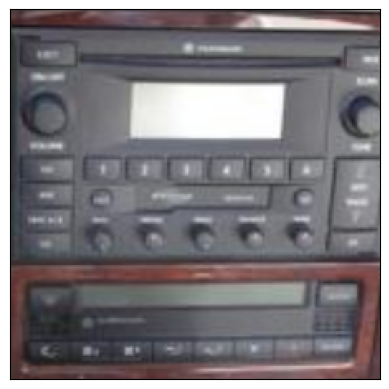

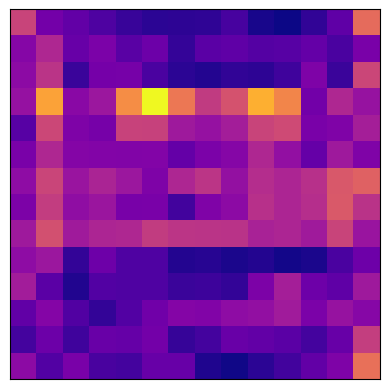

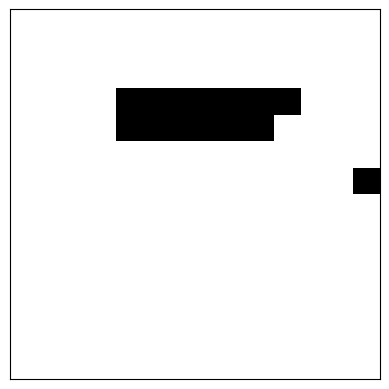

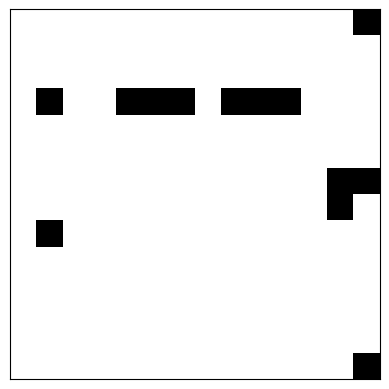

there are 16 images in the dataset
I now want to show the original image-head-query combination in the same format
Analyzing the image-query-head combination of image 4, query [9, 8], head 6
This observation achieves a Jaccard score of tensor(0.7345)


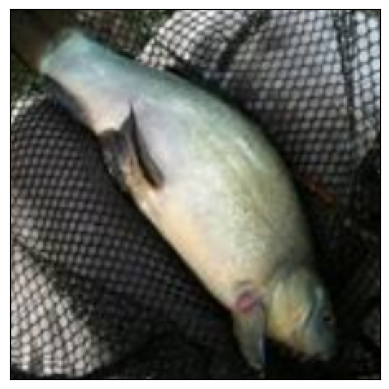

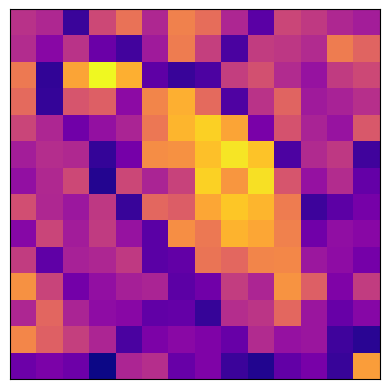

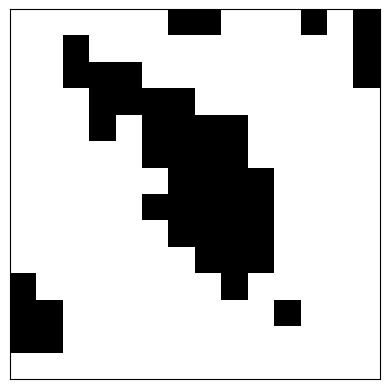

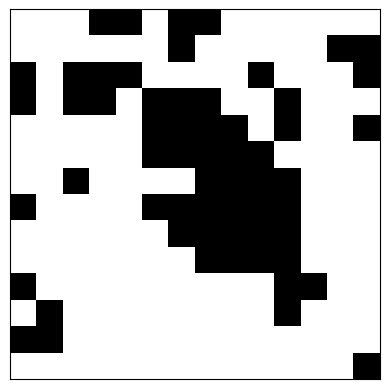

In [25]:
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/small'
os.chdir(diro)
if want_save:
  for filename in os.listdir():
    os.remove(filename)
dataset_16 = gen_dataset(16)
timimages = gen_im_list(16, 1, dataset_16, diro)
test_string = test_hypothesis(timimages)
print(f"there are {str(len(timimages))} images in the dataset")
for batch in range(16):
  plot_batchheads(batch, 1)
filo = open("ltx.txt", "w")
for batch in range(16):
  filo.write(write_batchheads(batch))
filo.close()
print("I now want to show the original image-head-query combination in the same format")
show_observation(timimages, 4, [9,8], 6, "orgimg")
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2')

Now generate a larger dataset by downloading more batches from Imagenette and by generating more query tokens per image. One observation will now be one image-token with 8 self-attention maps, one per head.

the features of this dataset has shapetorch.Size([59, 3, 224, 224])
the labels of this dataset has shape torch.Size([59])
there are 10 different labels
/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/large
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 
p0 = 0.375 std = 0.23, n = 1888dfreedoms = 57 alpha 0.01critical level of t-distribution = 2.66
Rejection region around 0.375 is lower than 0.36 or higher than 0.39.\\
\begin{center}\begin{tabular}{c|c|c}
\hline
Head & Freq & Result\\
\\hline
0 & 0.27542 & LOWER\\
\hline1 & 0.39831 & HIGHER\\
\hline2 & 0.48729 & HIGHER\\
\hline3 & 0.43644 & HIGHER\\
\hline4 & 0.41102 & HIGHER\\
\hline5 & 0.24576 & LOWER\\
\hline6 & 0.51271 & HIGHER\\
\hline7 & 0.33475 & LOWER\\
\hline\end{tabular}
\end{center}
The image-query-head combination with the highest Jaccard score is 52, [2, 7], 2
with a score of tensor(0.9798)
Analyzing the

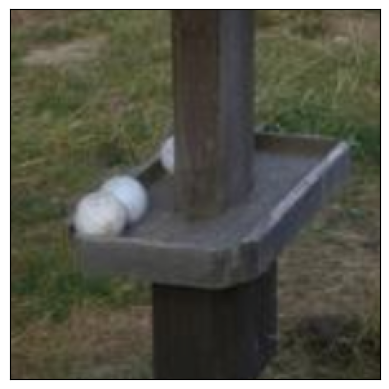

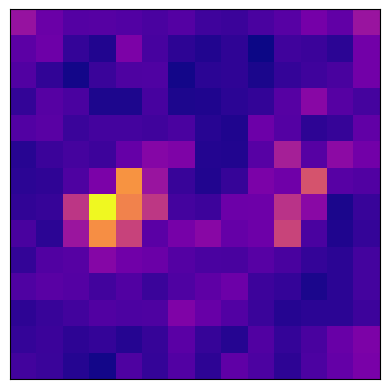

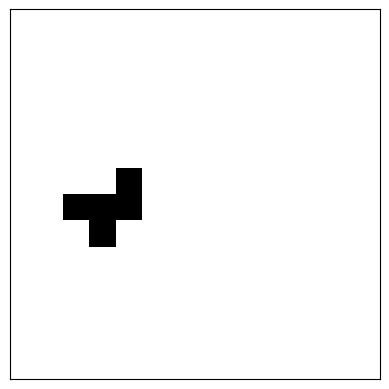

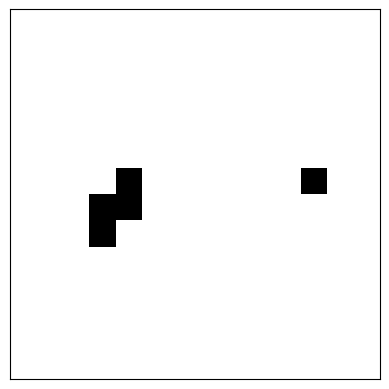

In [26]:
want_save = True
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/large'
os.chdir(diro)
if want_save:
  for filename in os.listdir():
    os.remove(filename)
dataset_59 = gen_dataset(59)
large_images = gen_im_list(59, 4, dataset_59, diro)
test_string = test_hypothesis(large_images)
filo = open("testlarge.txt", "w")
filo.write(test_string)
filo.close()
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2'
os.chdir(diro)

Now I train a model, then at the final layer take the transformed input embeddings, segment them into heads and train a linear classifier. I then discuss whether this linear classifier is different according to heads. I read out features and labels above

/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/small
<class 'torch.Tensor'>
torch.Size([16])
16
<class 'torch.Tensor'>
torch.Size([16, 12, 197, 64])
torch.Size([16, 151296])
18912


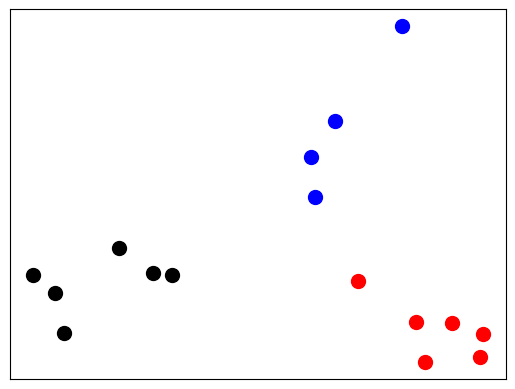

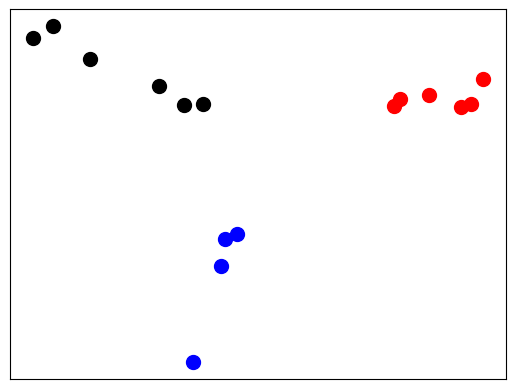

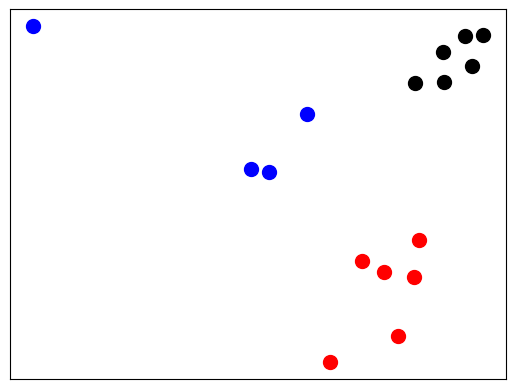

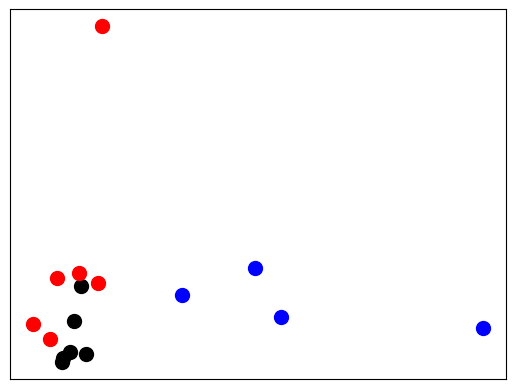

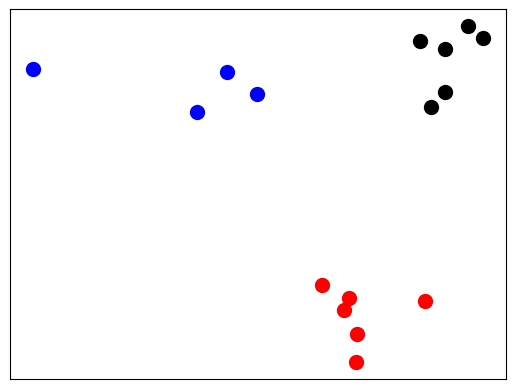

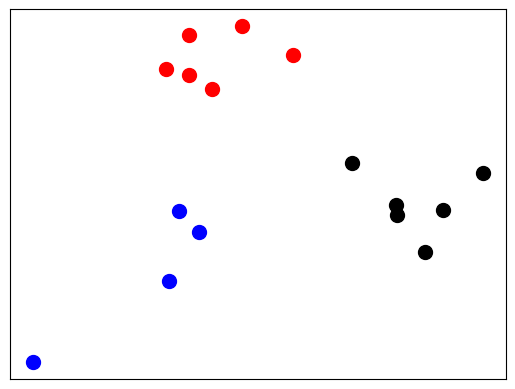

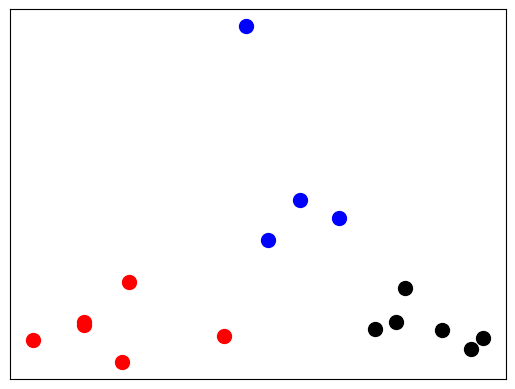

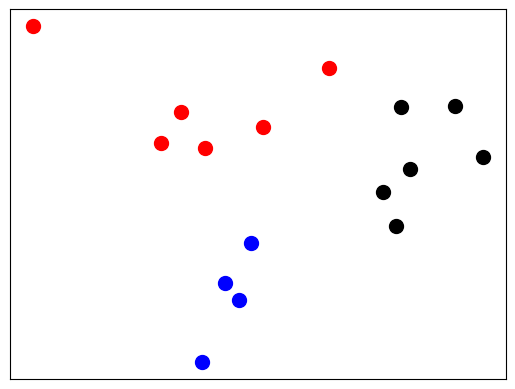

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[1.   1.   1.   1.   0.75 1.   1.   1.  ]
p0: 0.3333333333333333

p0 = 0.3333333333333333 std = 0.18, n = 32dfreedoms = 11 alpha 0.01critical level of t-distribution = 3.11
Rejection region around 0.3333333333333333 is lower than 0.24 or higher than 0.43.\\
\begin{center}\begin{tabular}{c|c|c}
\hline
Head & Freq & Result\\
\\hline
0 & 1.0 & HIGHER\\
\hline1 & 1.0 & HIGHER\\
\hline2 & 1.0 & HIGHER\\
\hline3 & 1.0 & HIGHER\\
\hline4 & 0.75 & HIGHER\\
\hline5 & 1.0 & HIGHER\\
\hline6 & 1.0 & HIGHER\\
\hline7 & 1.0 & HIGHER\\
\hline\end{tabular}
\end{center}
Now consider the difference between the average success of a given head and the average success of all other heads

p0 = 0 std = 2.77, n = 4dfreedoms = 95 alpha 0.01critical level of t-distribution = 2.63
Rejection region around 0 is lower than -0.74 or higher than 0.74.\\
\begin{center}\begin{tabular}{c|c|c}
\hline


In [27]:
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/small'
os.chdir(diro)
perform_classification(dataset_16, "small")
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2'
os.chdir(diro)

/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/large
<class 'torch.Tensor'>
torch.Size([59])
59
<class 'torch.Tensor'>
torch.Size([59, 12, 197, 64])
torch.Size([59, 151296])
18912


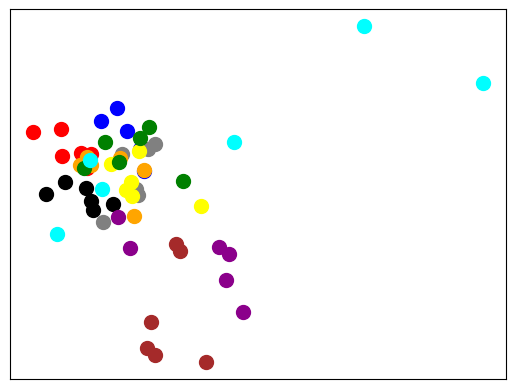

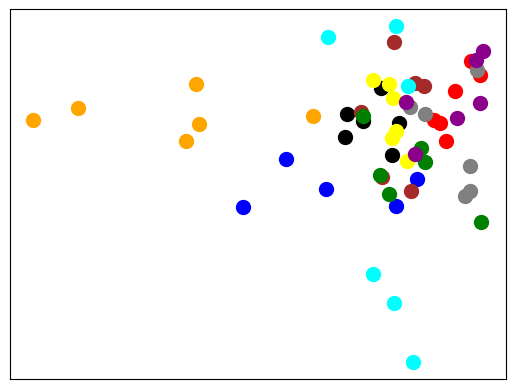

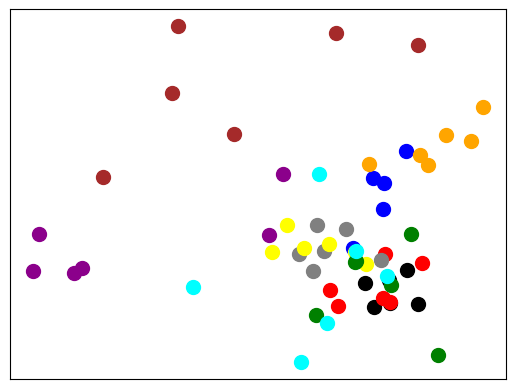

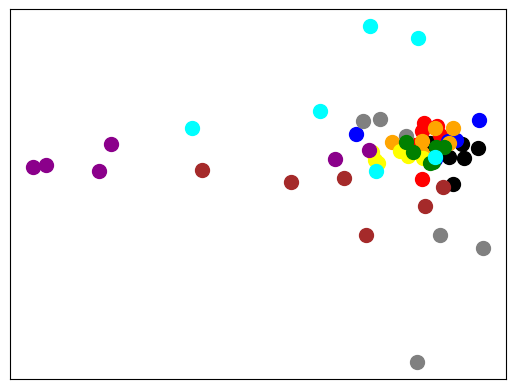

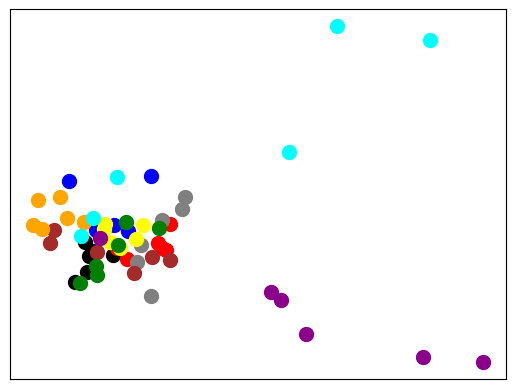

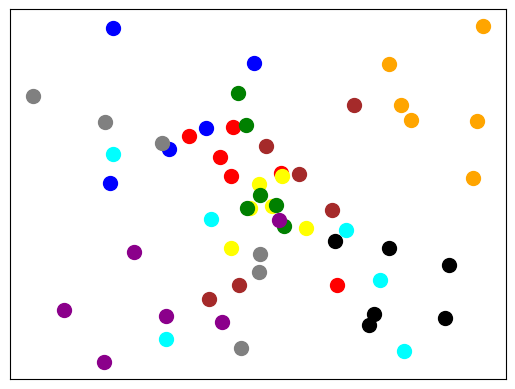

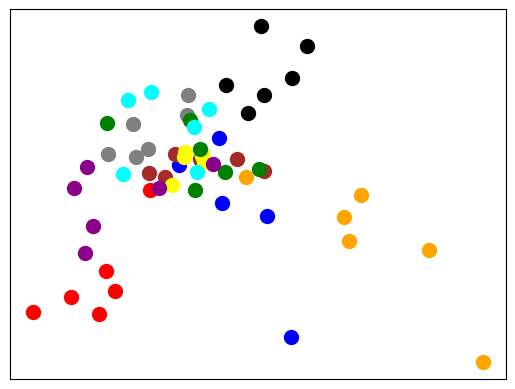

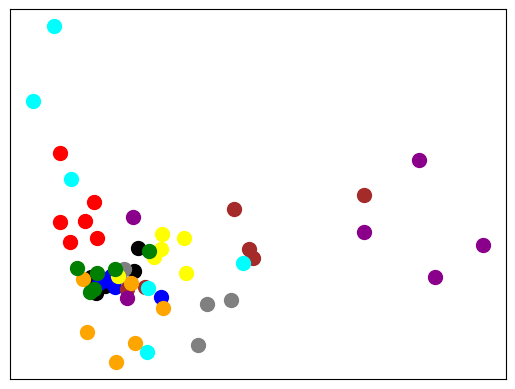

[[1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]]
[0.75 0.75 0.75 0.75 0.92 0.83 0.92 0.58]
p0: 0.1

p0 = 0.1 std = 0.42, n = 96dfreedoms = 11 alpha 0.01critical level of t-distribution = 3.11
Rejection region around 0.1 is lower than -0.03 or higher than 0.23.\\
\begin{center}\begin{tabular}{c|c|c}
\hline
Head & Freq & Result\\
\\hline
0 & 0.75 & HIGHER\\
\hline1 & 0.75 & HIGHER\\
\hline2 & 0.75 & HIGHER\\
\hline3 & 0.75 & HIGHER\\
\hline4 & 0.91667 & HIGHER\\
\hline5 & 0.83333 & HIGHER\\
\hline6 & 0.91667 & HIGHER\\
\hline7 & 0.58333 & HIGHER\\
\hline\end{tabular}
\end{center}
Now consider the difference between the average success of a given head and the average success of all other heads

p0 = 0 std = 2.48, n = 12dfreedoms 

In [30]:
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2/large'
os.chdir(diro)
perform_classification(dataset_59, "large")
diro = '/content/drive/MyDrive/Colab Notebooks/ATDL/HA3_2'
os.chdir(diro)